# 檢視與處理 Outliers
### 為何會有 outliers, 常見的 outlier 原因
* 未知值，隨意填補 (約定俗成的代入)，如年齡常見 0,999
* 可能的錯誤紀錄/手誤/系統性錯誤，如某本書在某筆訂單的銷售量 = 1000 本

# [作業目標]
- 依照下列提示與引導, 以幾種不同的方式, 檢視可能的離群值

# [作業重點]
- 從原始資料篩選可能的欄位, 看看那些欄位可能有離群值 (In[3], Out[3])
- 繪製目標值累積密度函數(ECDF)的圖形, 和常態分布的累積密度函數對比, 以確認是否有離群值的情形 (In[6], Out[6], In[7], Out[7])

In [1]:
# Import 需要的套件
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# 設定 data_path
dir_data = './data/'

In [2]:
f_app = os.path.join(dir_data, 'application_train.csv')
print('Path of read in data: %s' % (f_app))
app_train = pd.read_csv(f_app)
app_train.head()

Path of read in data: ./data/application_train.csv


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
# app_train.dtypes
list(app_train.columns[0:5])

['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR']

In [35]:
int_f = []
float_f = []
object_f = []

for dtype, feature in zip(app_train.dtypes, app_train.columns):
    if dtype == 'float64':
        float_f.append(feature)
    elif dtype == 'int64':
        int_f.append(feature)
    else:
        object_f.append(feature)
print(f'{len(int_f)} Integer Features : {int_f}\n')
print(f'{len(float_f)} Float Features : {float_f}\n')
print(f'{len(object_f)} Object Features : {object_f}')

41 Integer Features : ['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

65 Float Features : ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'OW

In [51]:
# Whether each element in the DataFrame is contained in values.
dtype_select = [np.dtype('int64')]
type(dtype_select)

SK_ID_CURR                     True
TARGET                        False
CNT_CHILDREN                   True
AMT_INCOME_TOTAL               True
AMT_CREDIT                     True
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY      True
AMT_REQ_CREDIT_BUREAU_WEEK     True
AMT_REQ_CREDIT_BUREAU_MON      True
AMT_REQ_CREDIT_BUREAU_QRT      True
AMT_REQ_CREDIT_BUREAU_YEAR     True
Length: 106, dtype: bool

## 請參考 HomeCredit_columns_description.csv 的欄位說明，觀察並列出三個你覺得可能有 outlier 的欄位並解釋可能的原因

In [75]:
# 先篩選數值型的欄位
"""
YOUR CODE HERE, fill correct data types (for example str, float, int, ...)
"""
dtype_select = [np.dtype('int64'), np.dtype('float64')]

# 比較 dtypes 裡面有誰是 int64 or float64，值就只有兩種，所以 list 裡面只要兩個東西就可以
numeric_columns = list(app_train.columns[list(app_train.dtypes.isin(dtype_select))])
len(numeric_columns)

RangeIndex(start=0, stop=307511, step=1)

Numbers of remain 73 columns


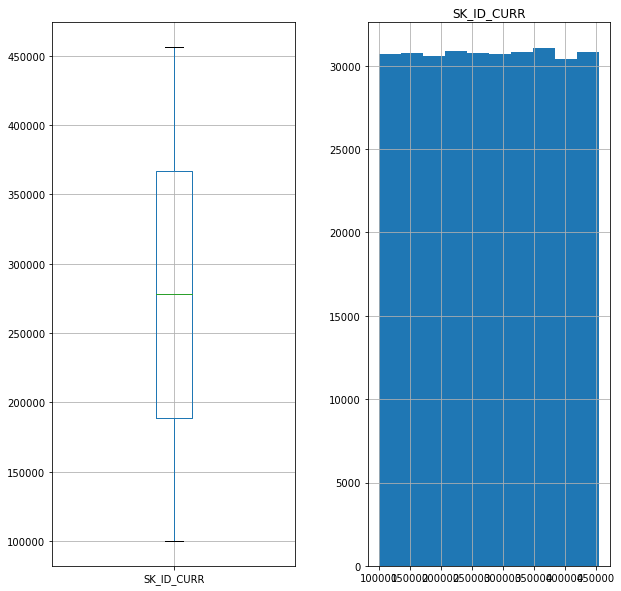

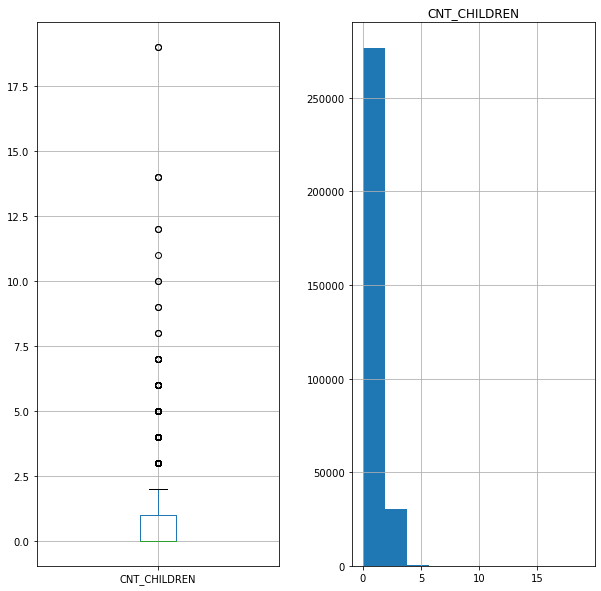

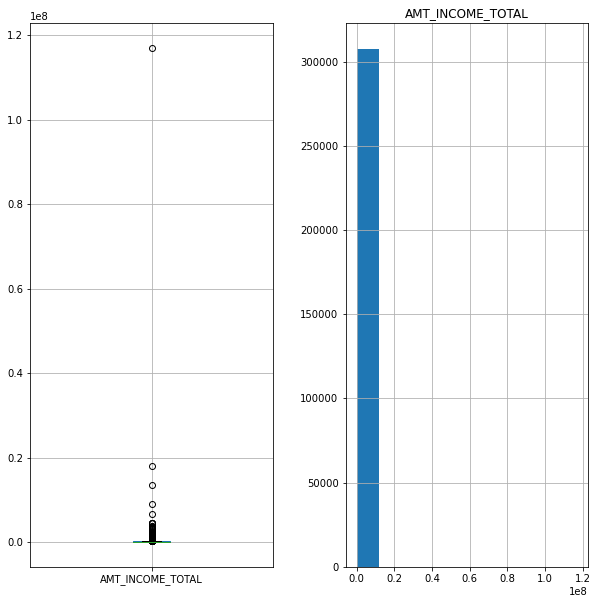

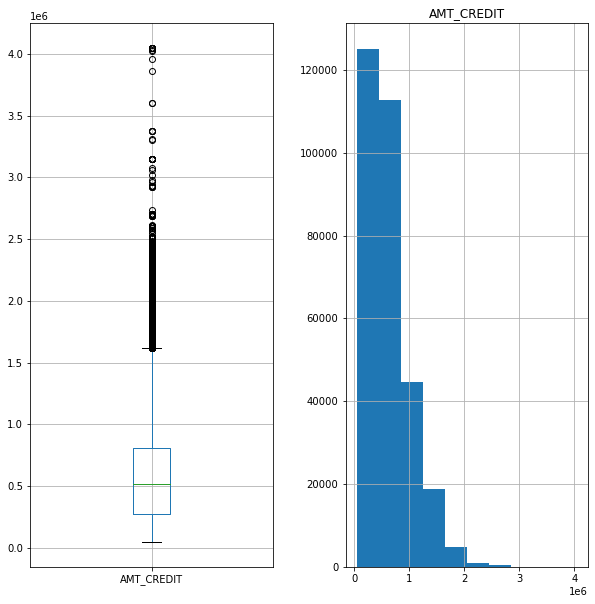

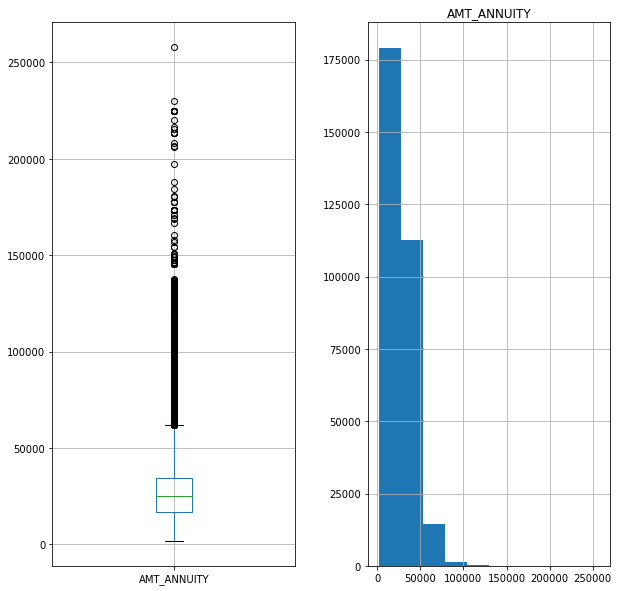

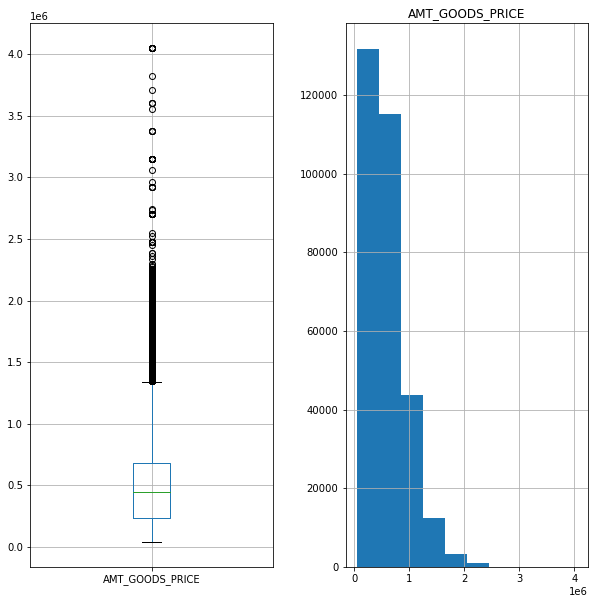

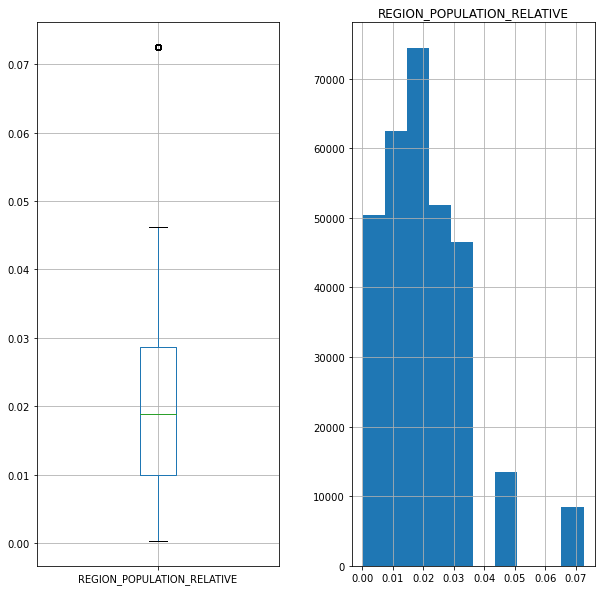

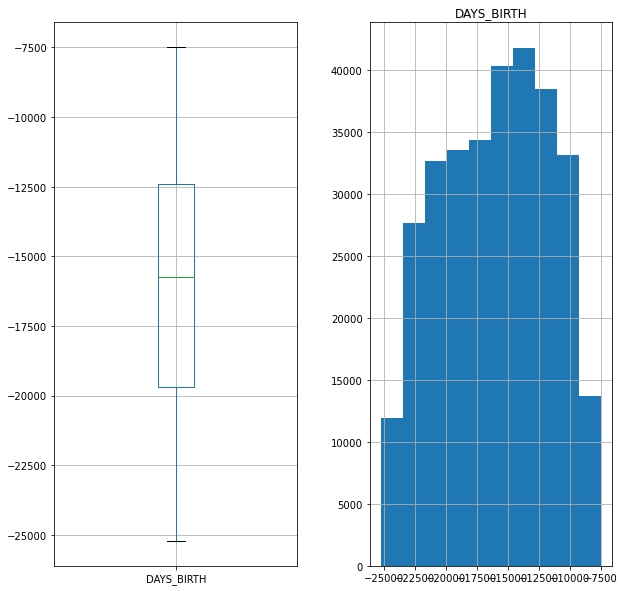

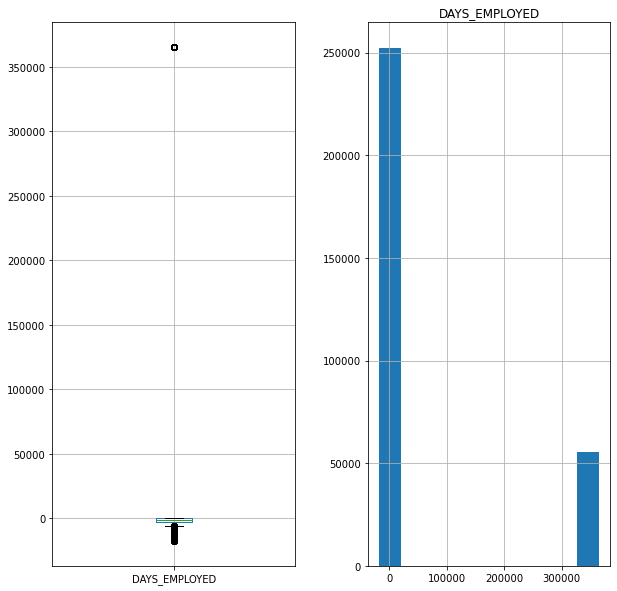

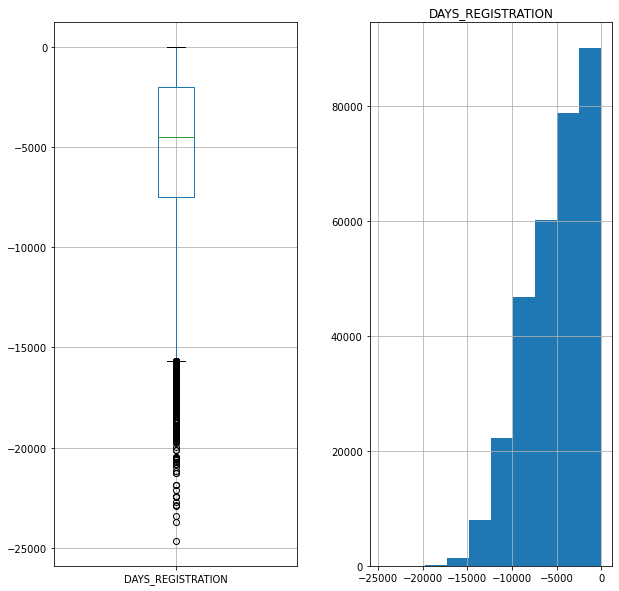

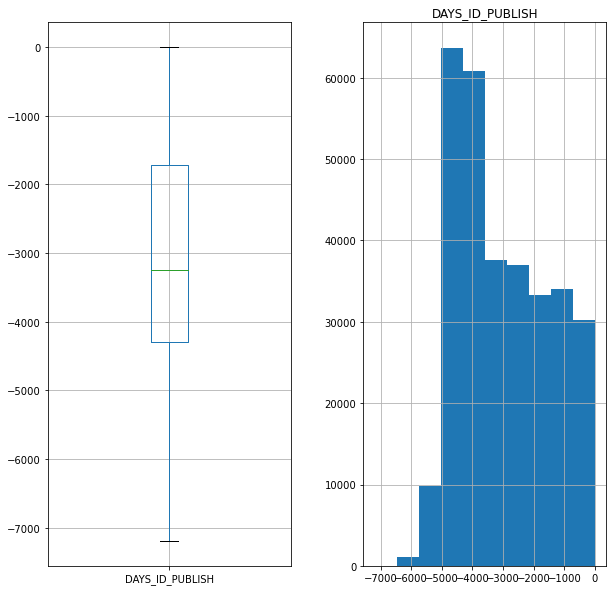

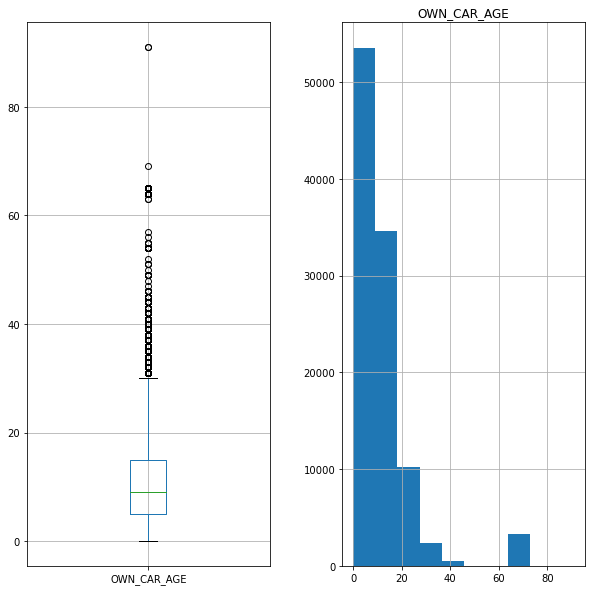

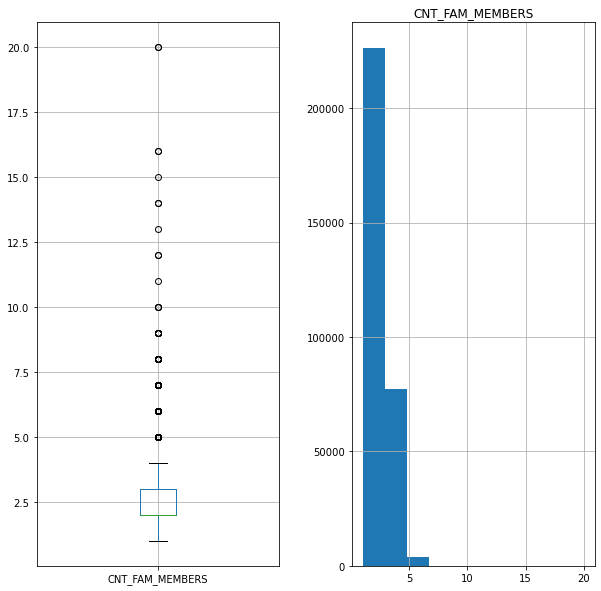

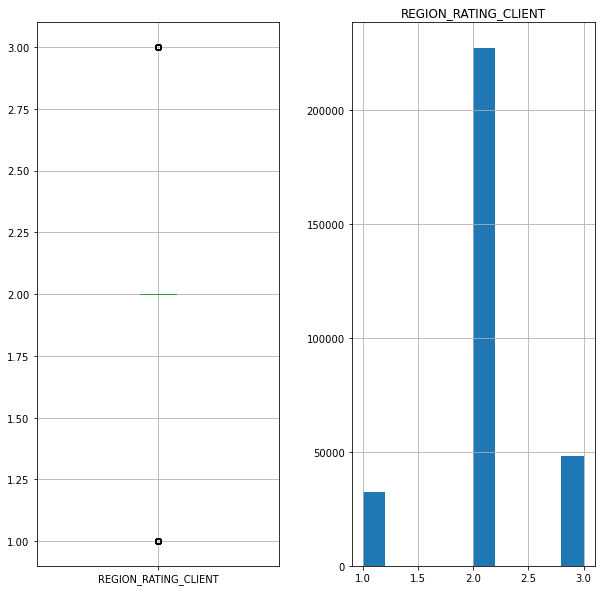

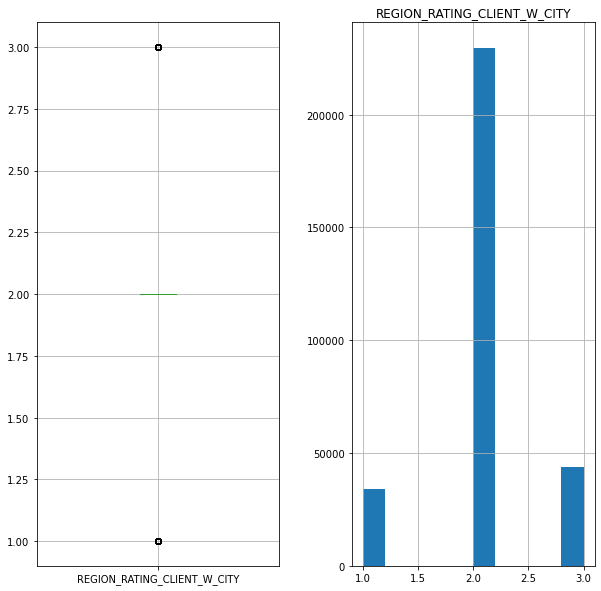

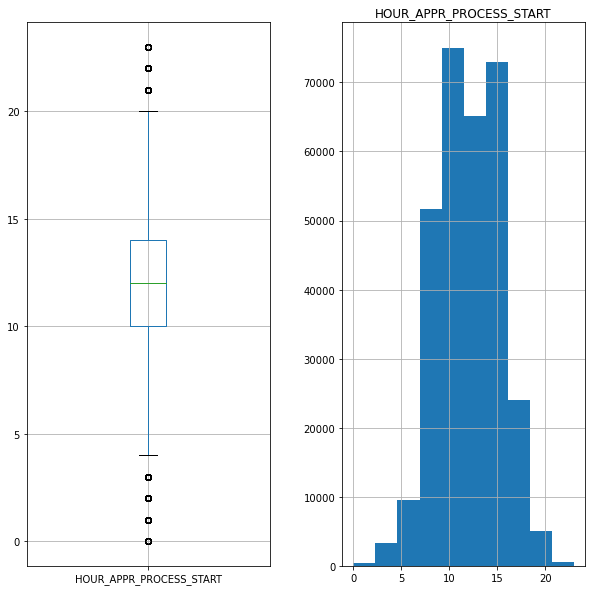

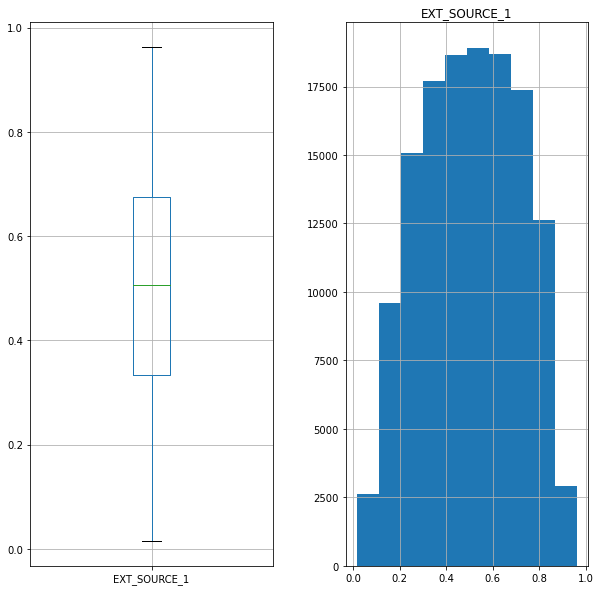

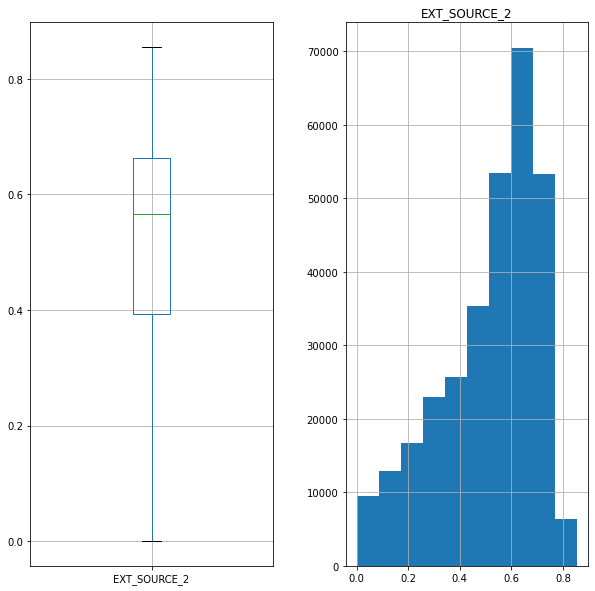

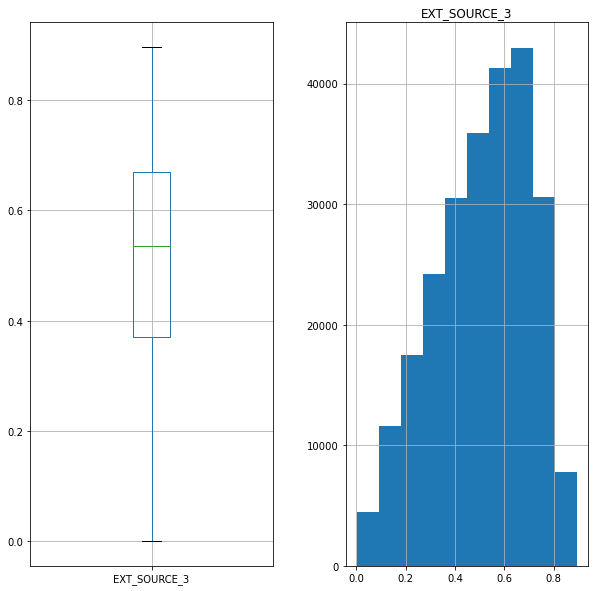

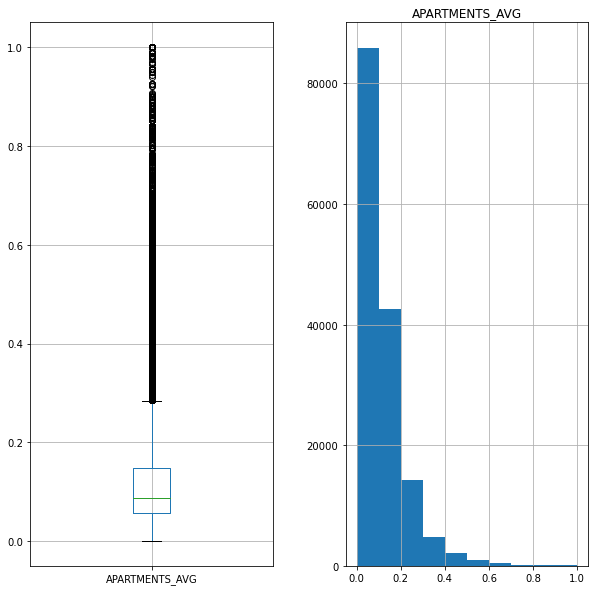

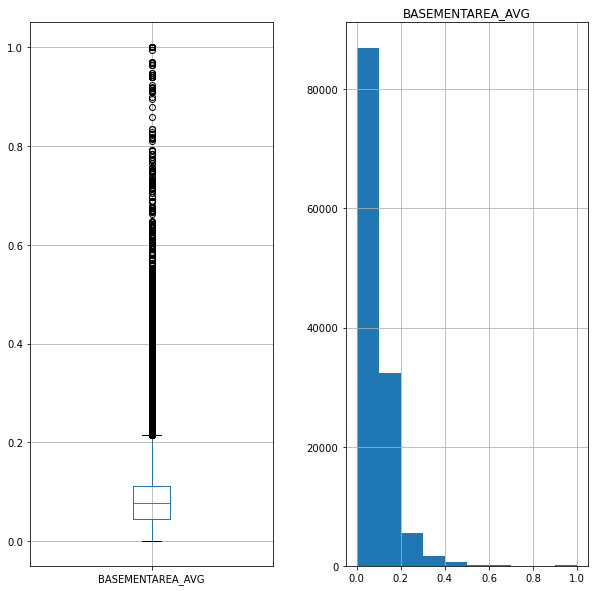

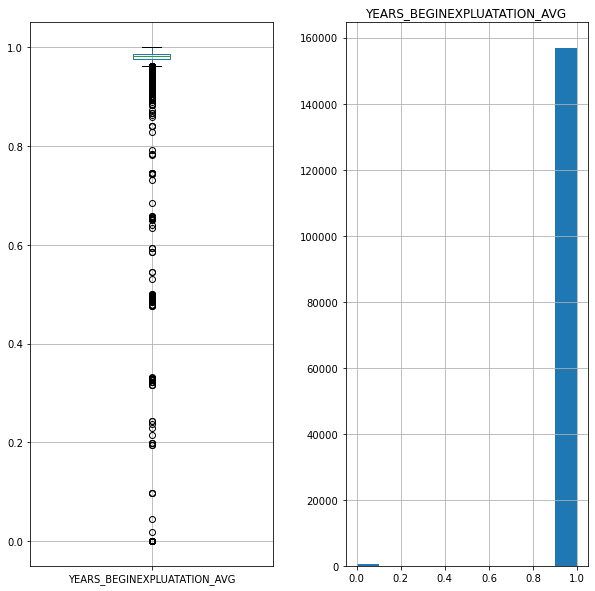

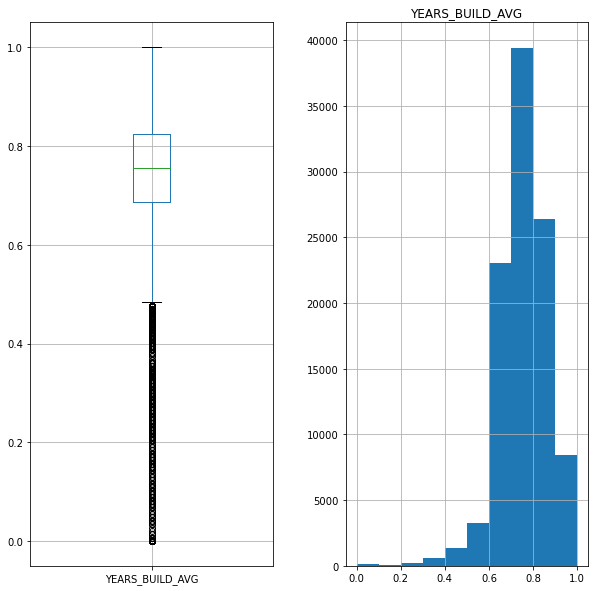

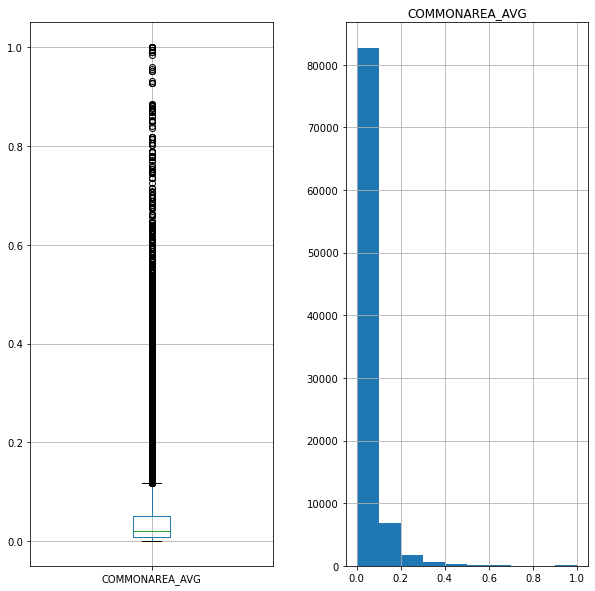

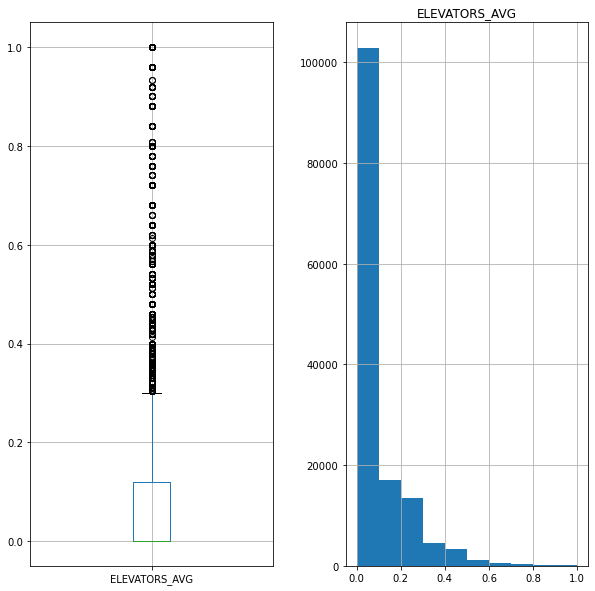

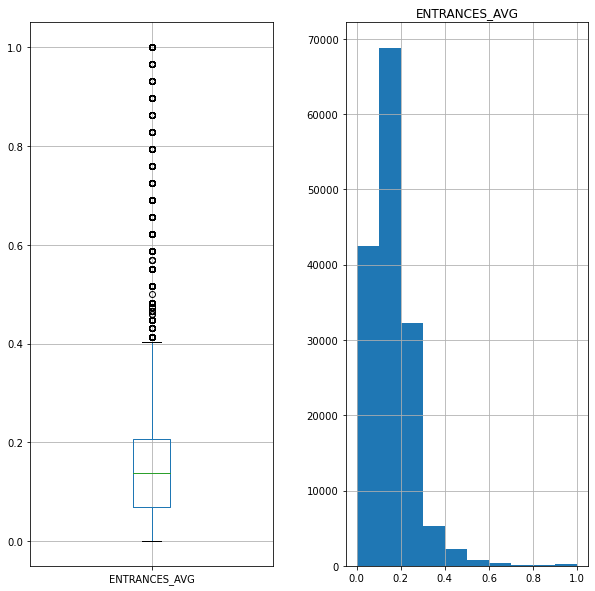

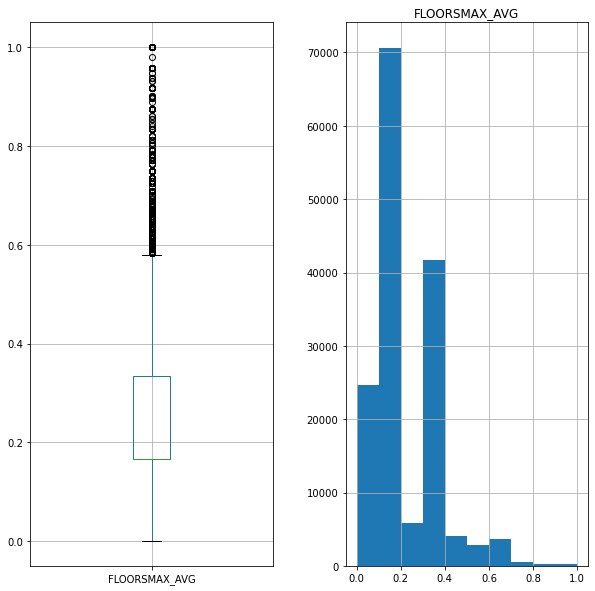

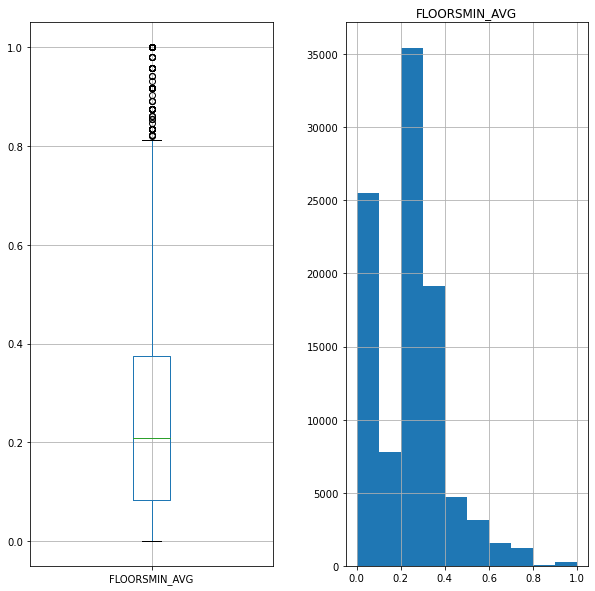

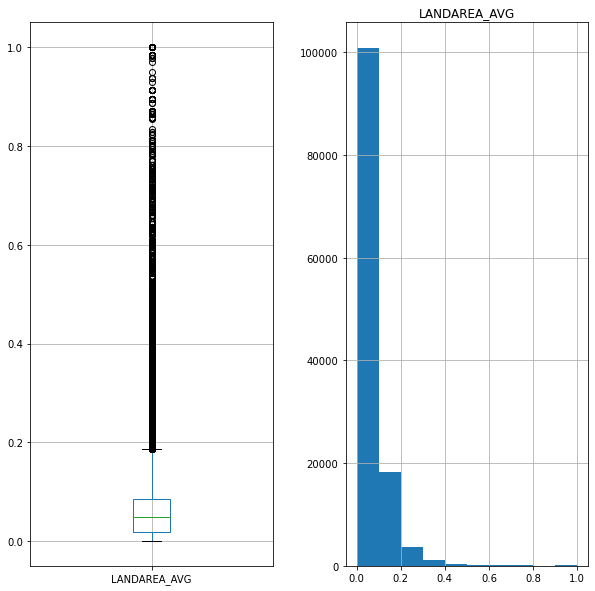

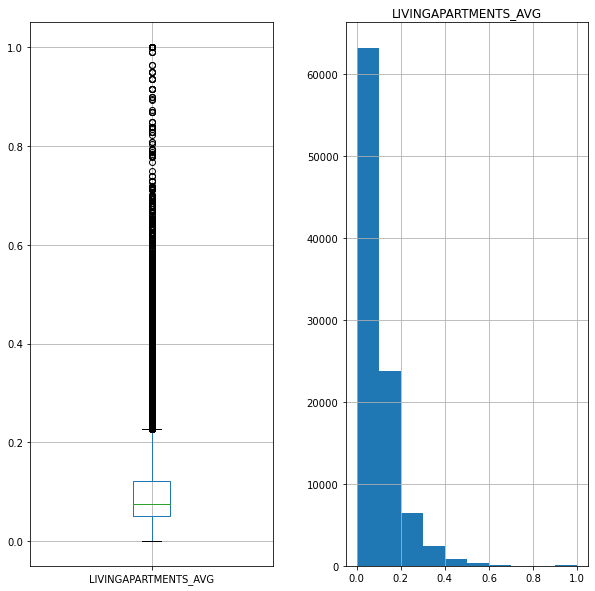

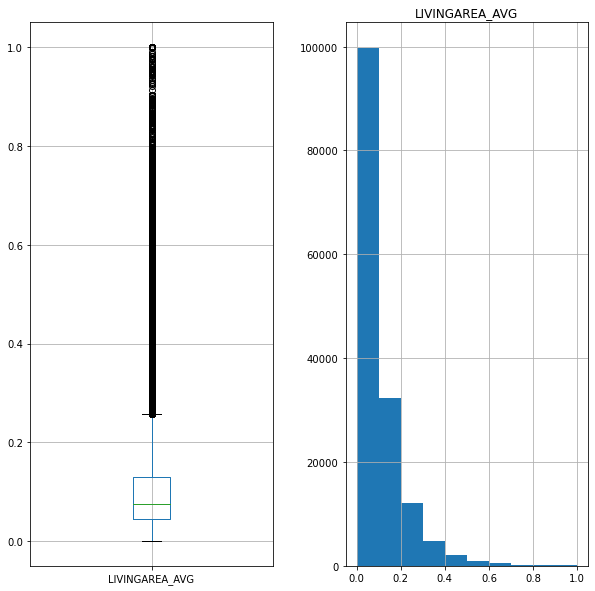

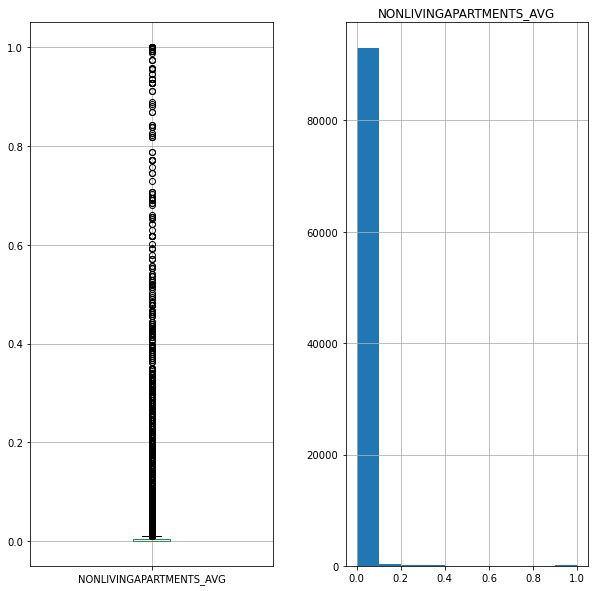

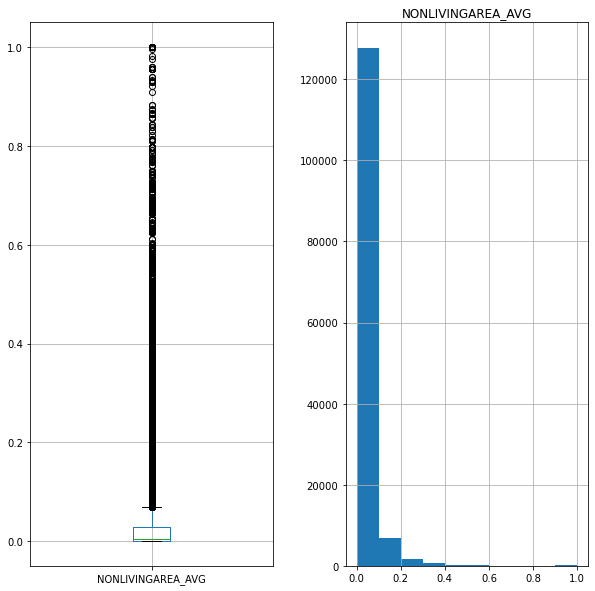

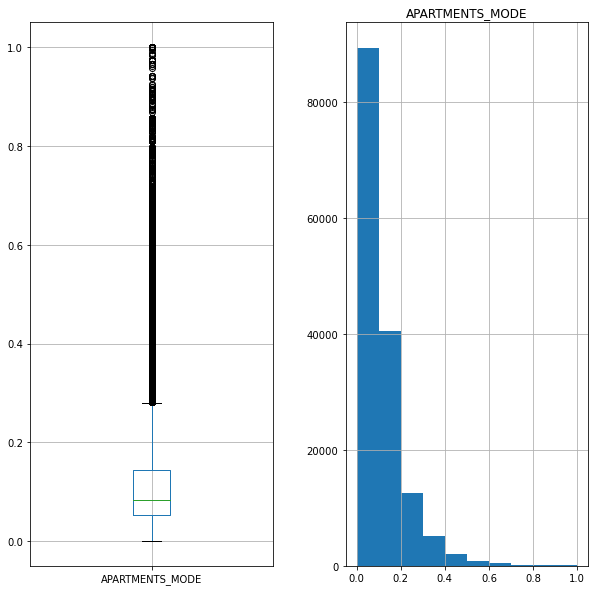

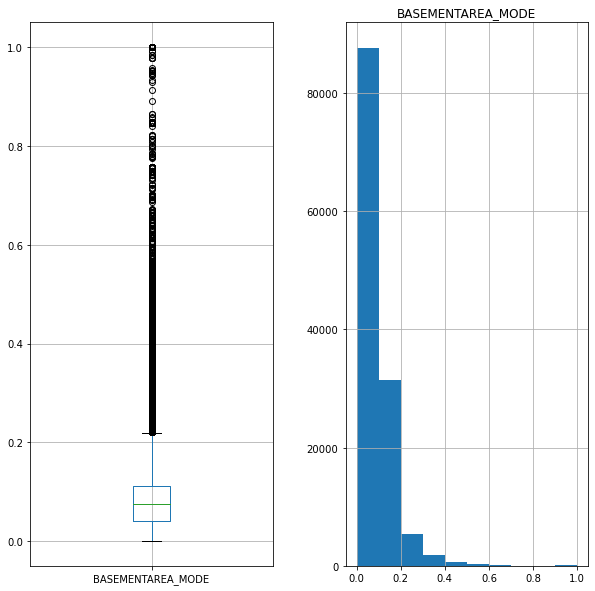

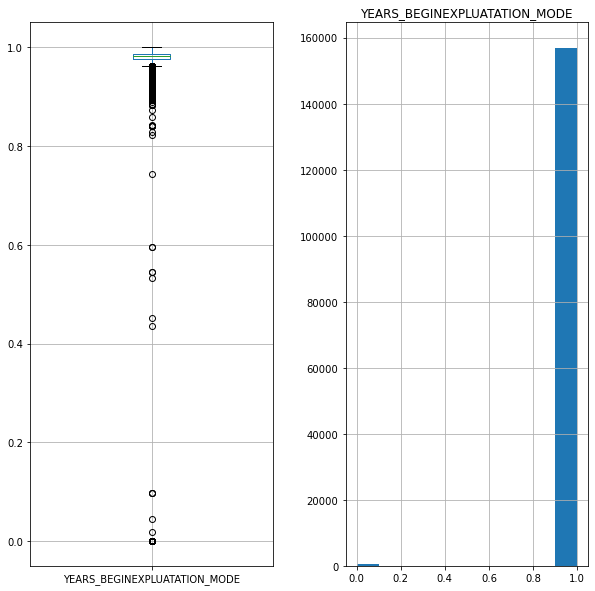

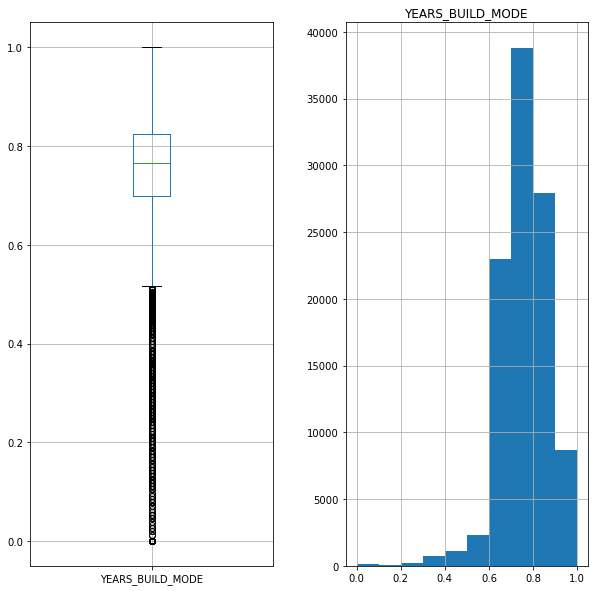

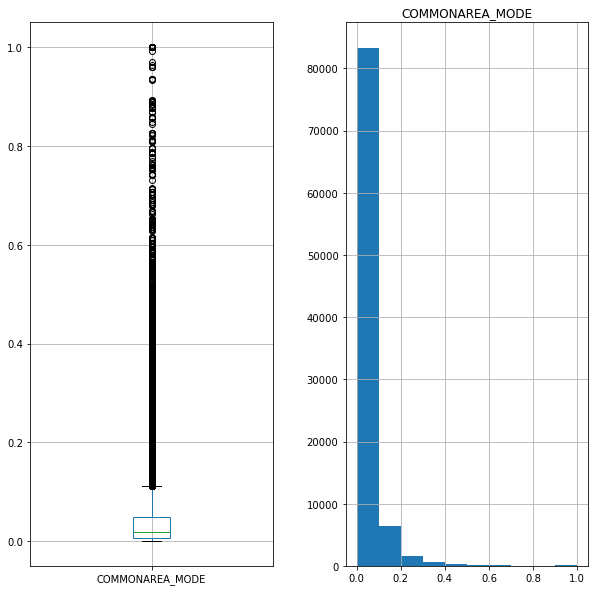

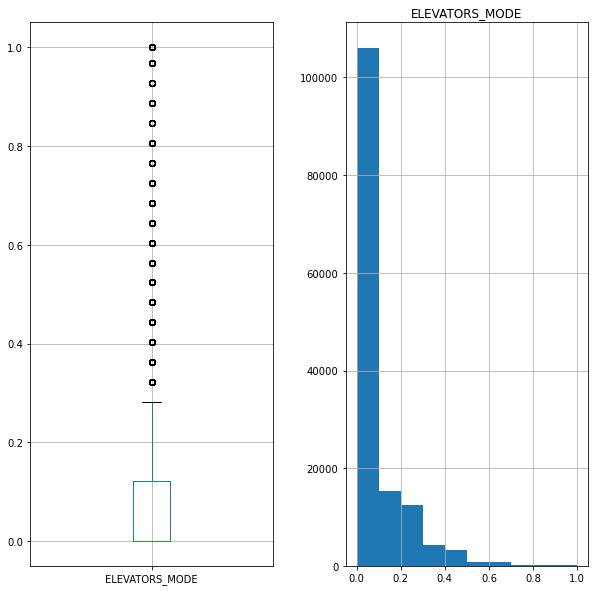

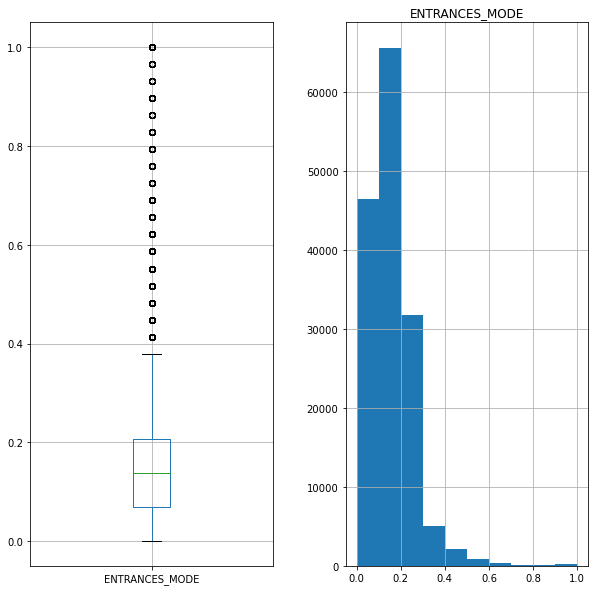

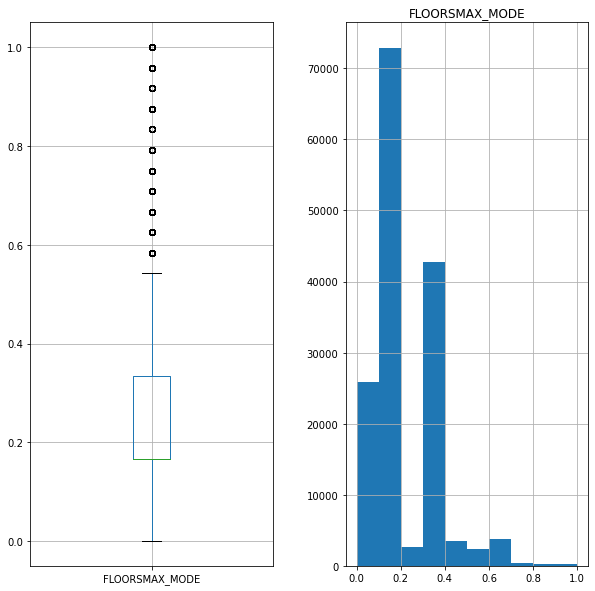

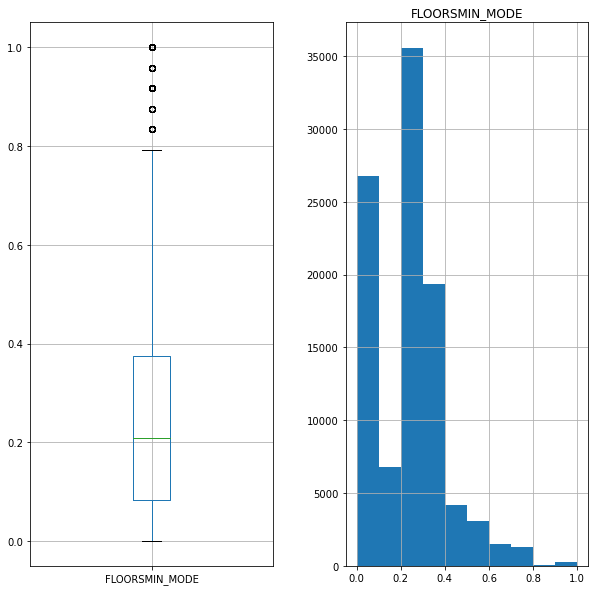

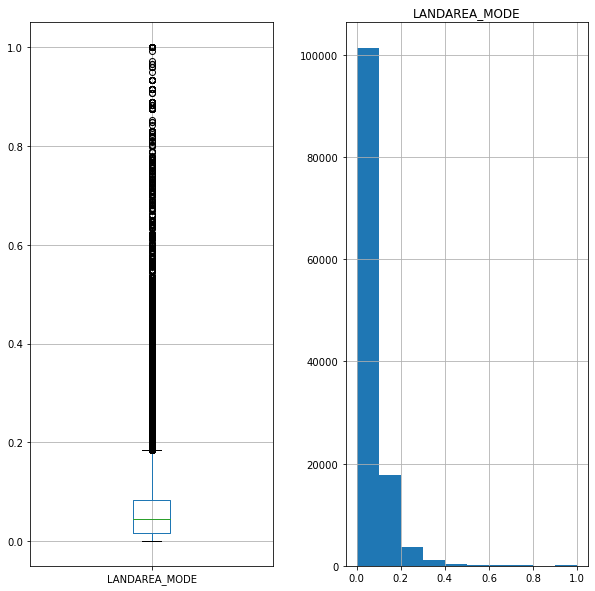

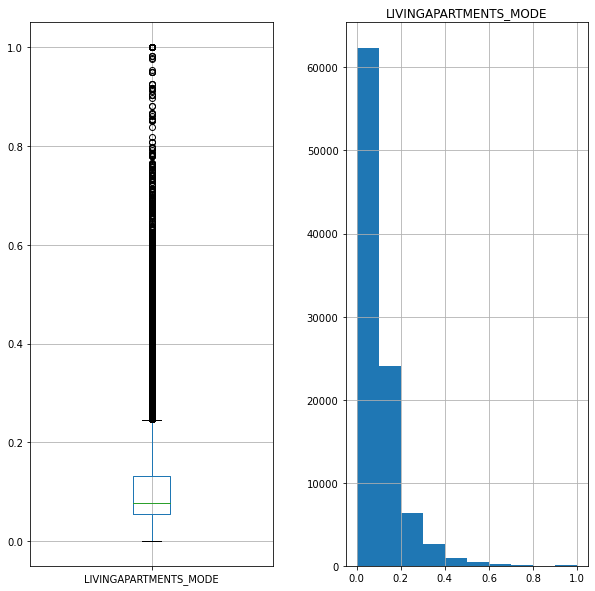

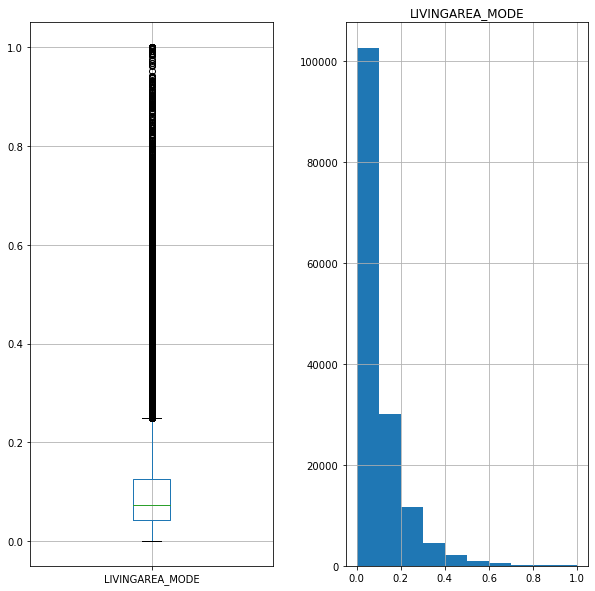

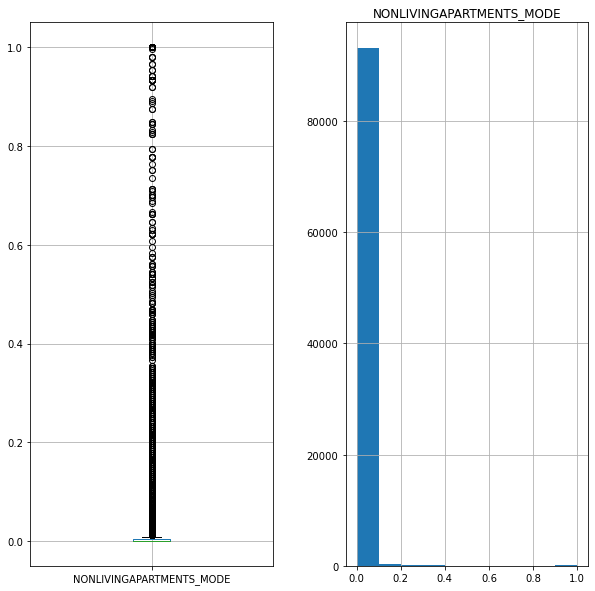

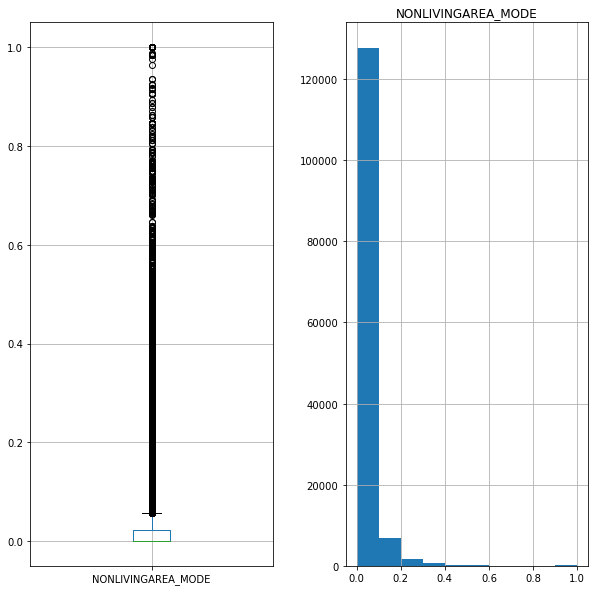

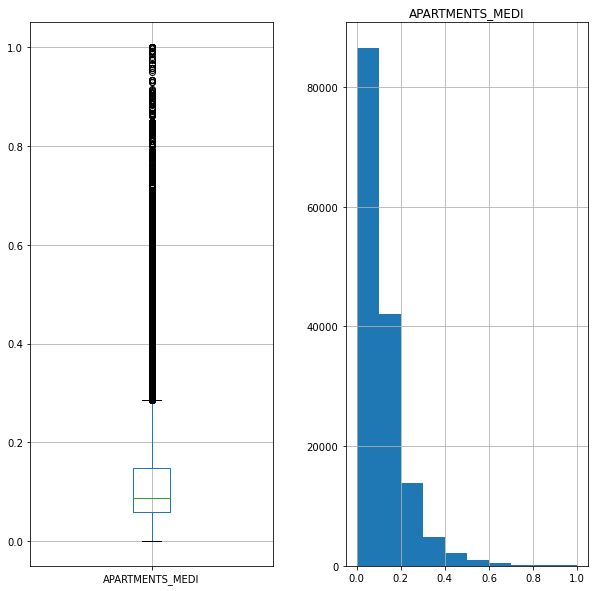

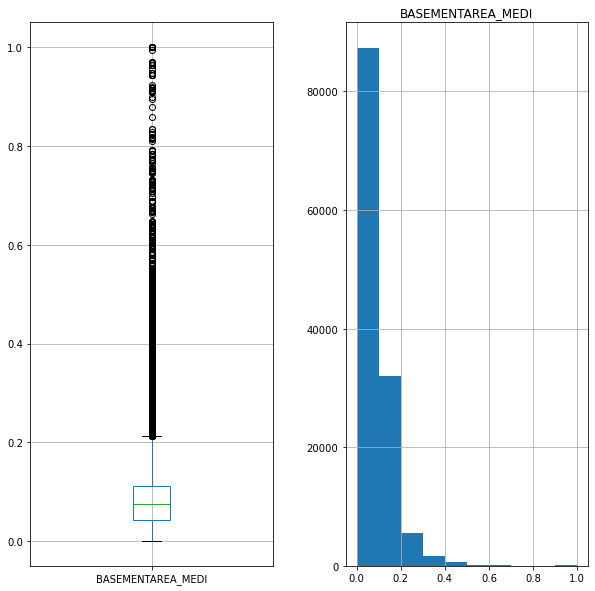

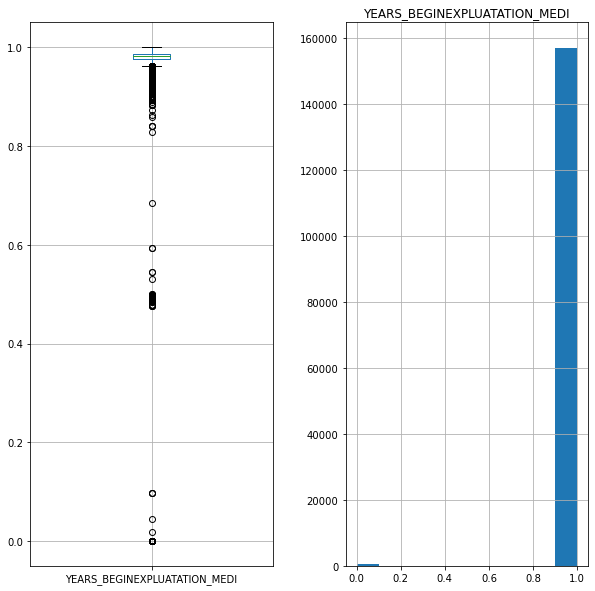

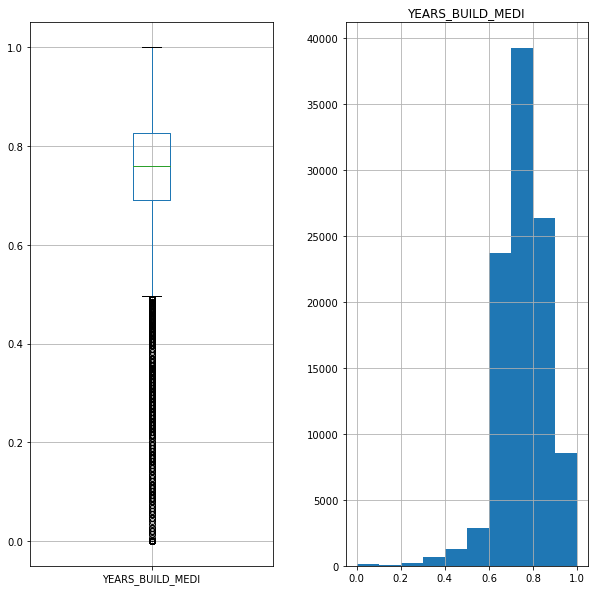

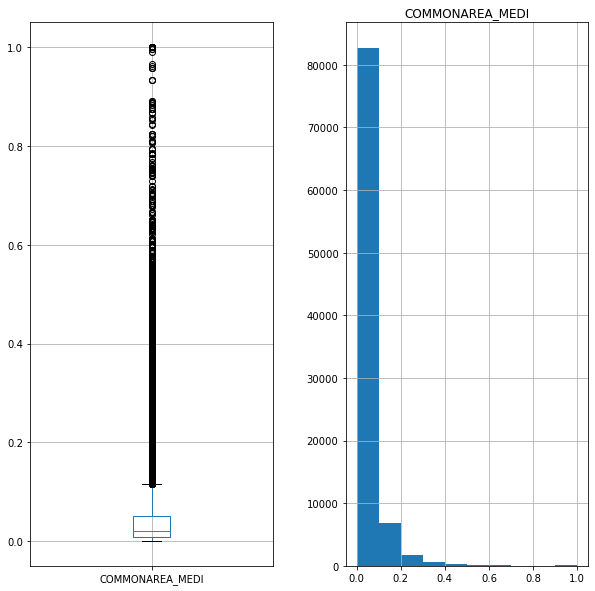

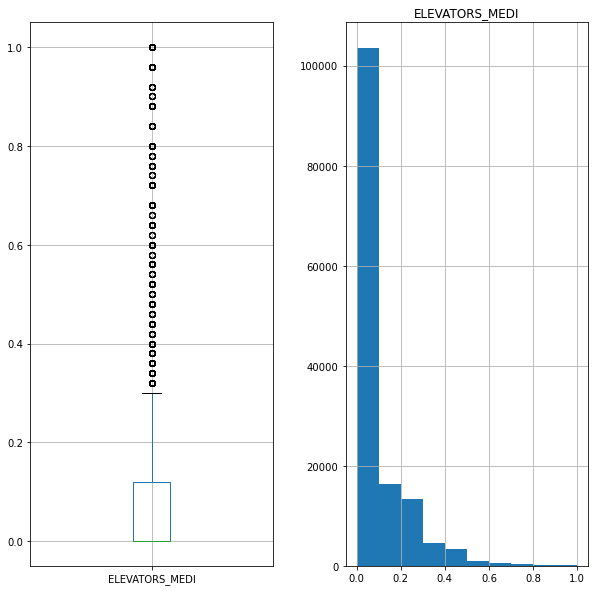

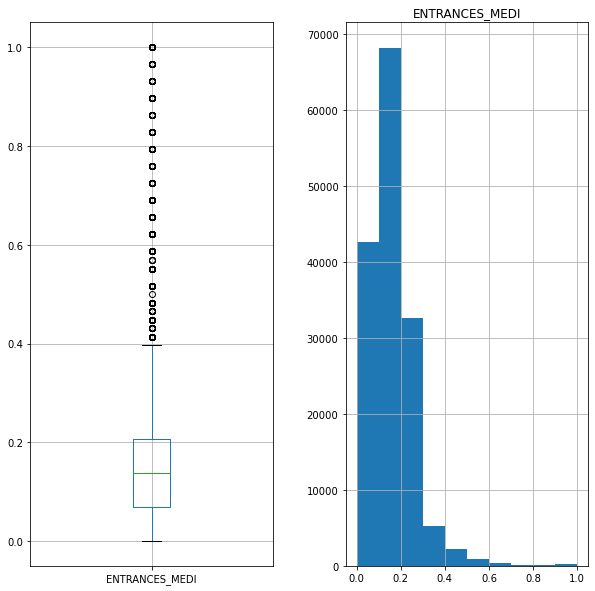

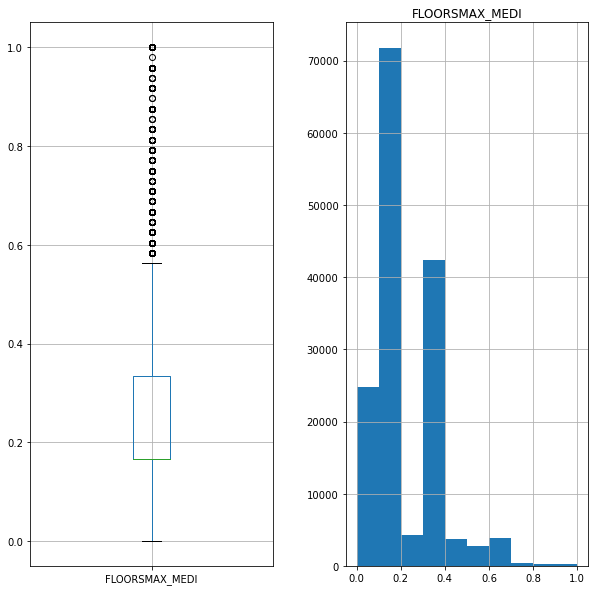

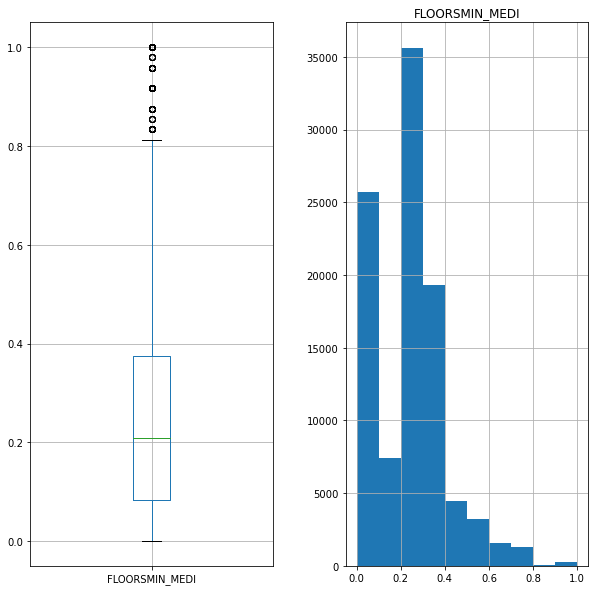

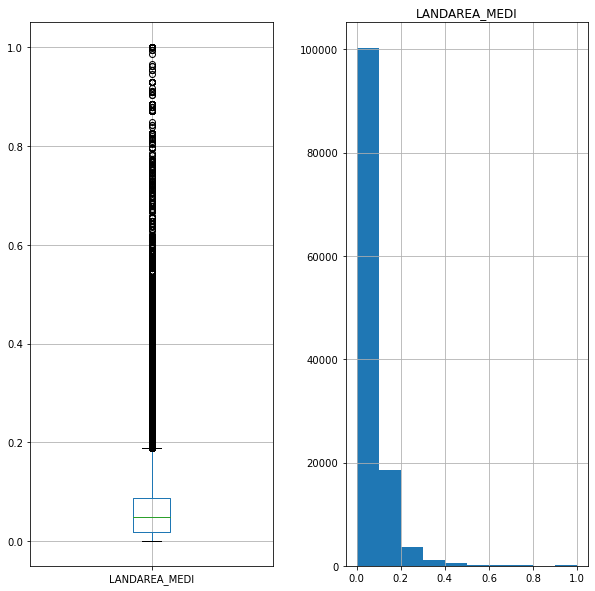

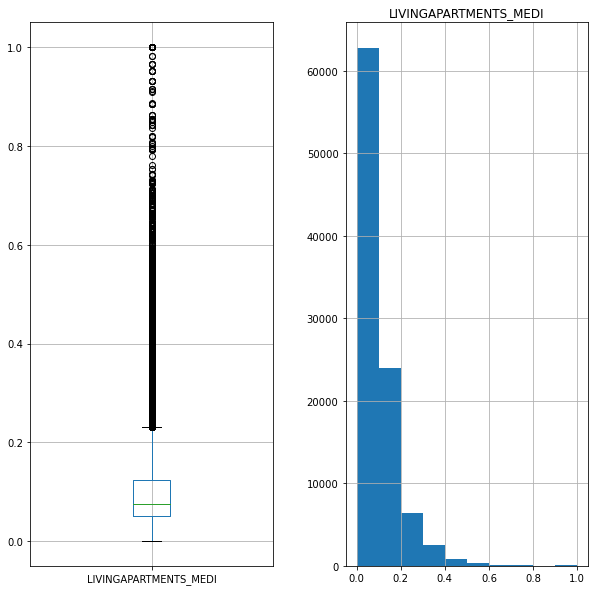

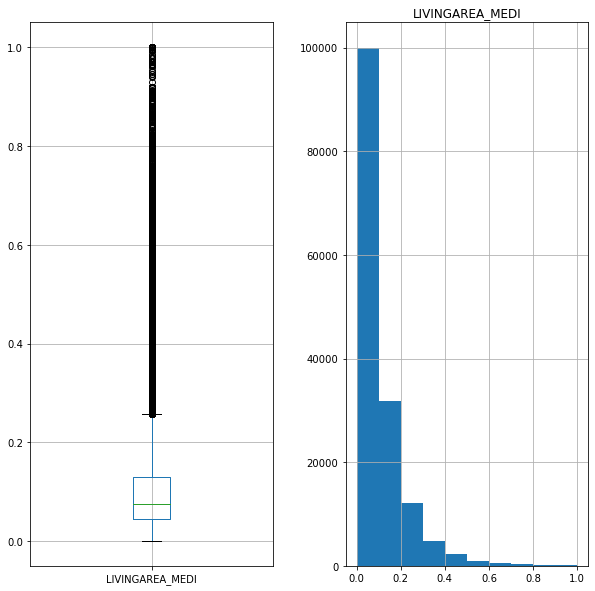

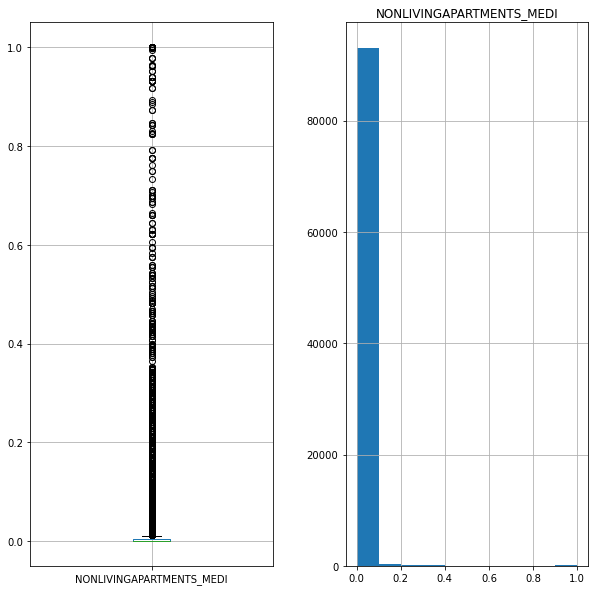

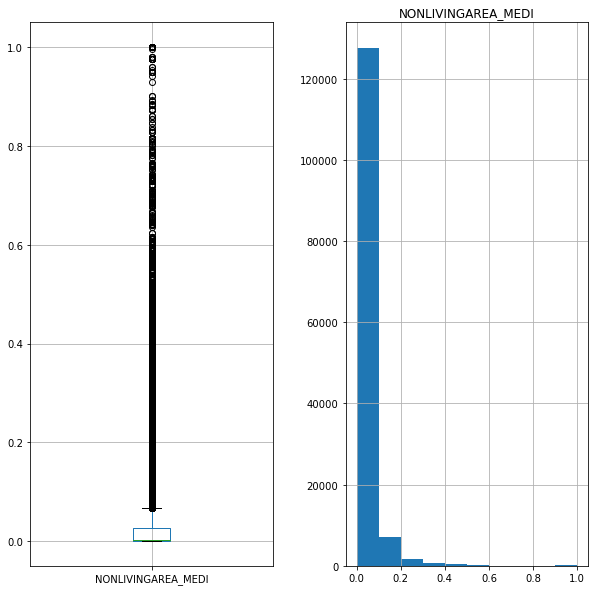

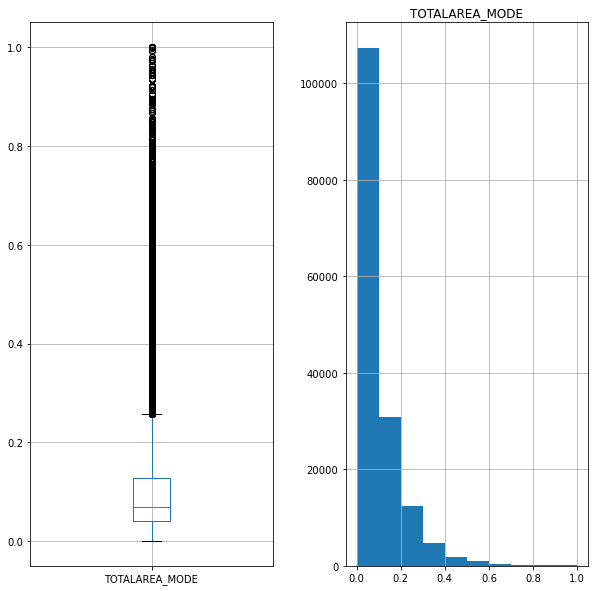

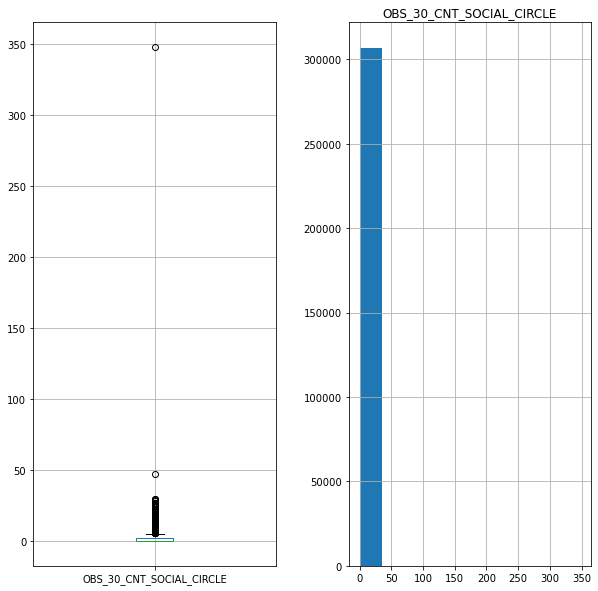

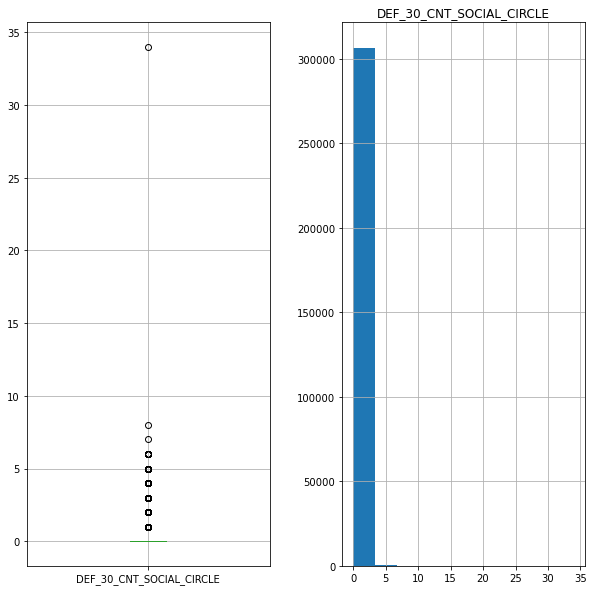

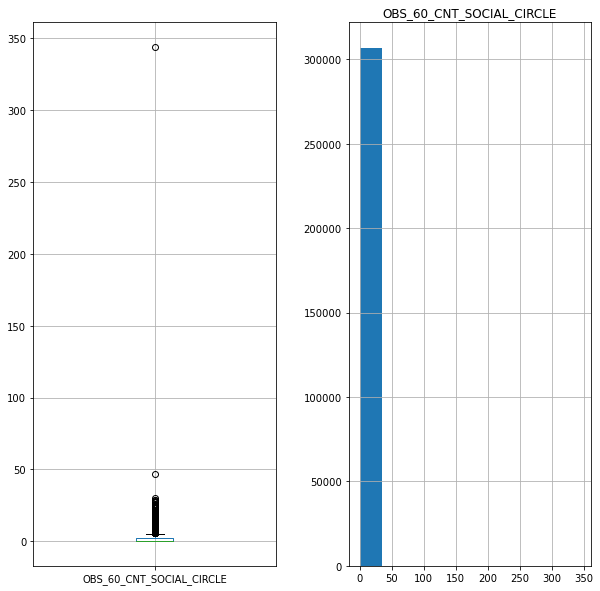

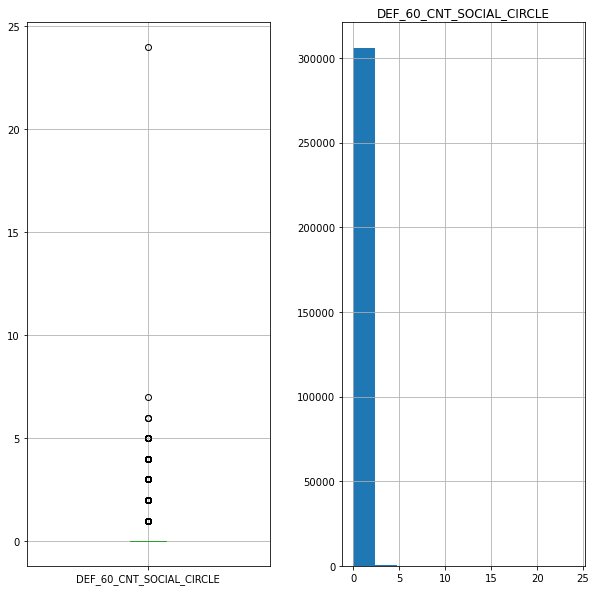

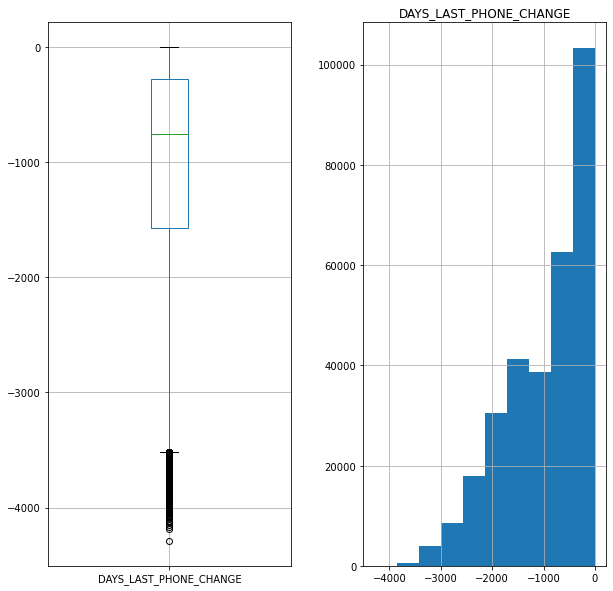

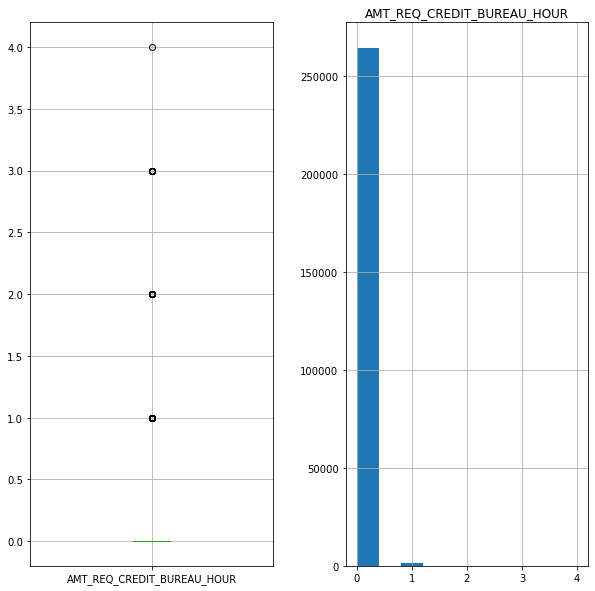

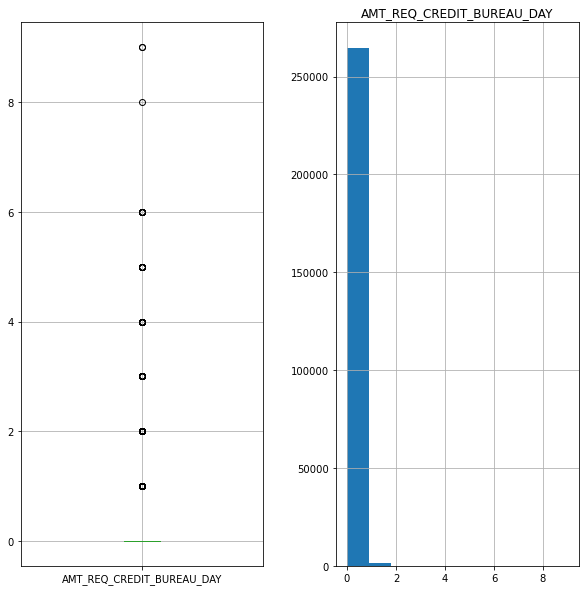

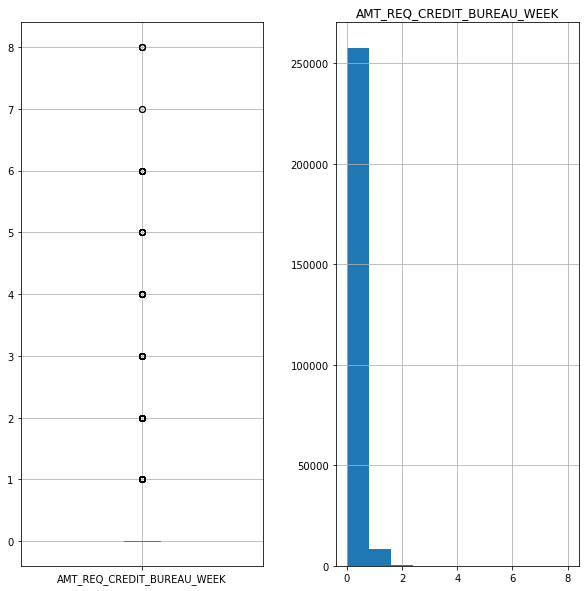

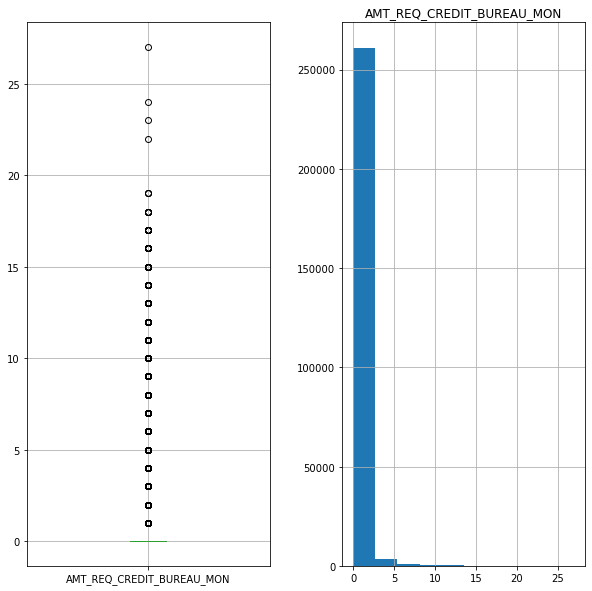

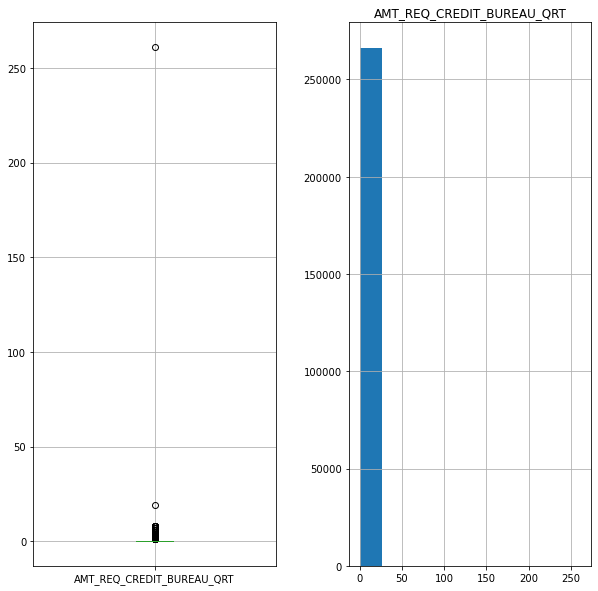

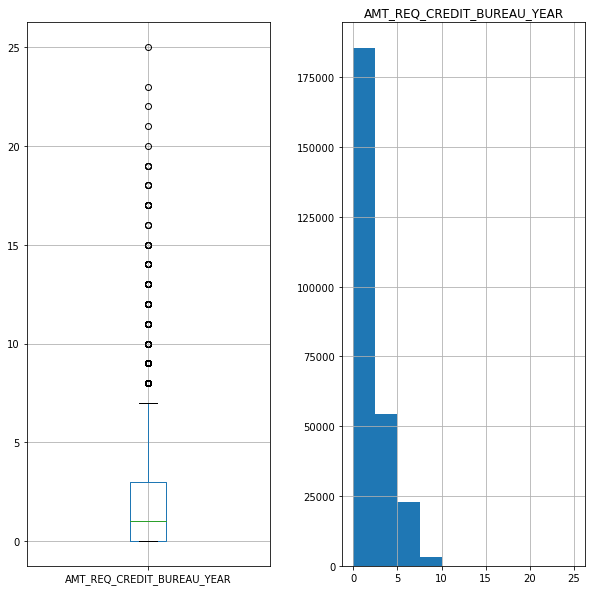

In [81]:
# 再把只有 2 值 (通常是 0,1) 的欄位去掉
numeric_columns = list(app_train[numeric_columns].columns[list(app_train[numeric_columns].apply(lambda x:len(x.unique())!=2 ))])
print("Numbers of remain %1.0d columns" % len(numeric_columns))

# 檢視這些欄位的數值範圍
for col in numeric_columns:
    """
    Your CODE HERE, make the box plot
    """
#     app_train[col].plot.box(title=col)
#     plt.xlabel(col)
#     plt.ylabel("count")
#     plt.show()
    fig = plt.figure(figsize = (10, 10))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    app_train.boxplot(column = col, ax = ax1)
    app_train.hist(column = col, ax= ax2)
    plt.show();

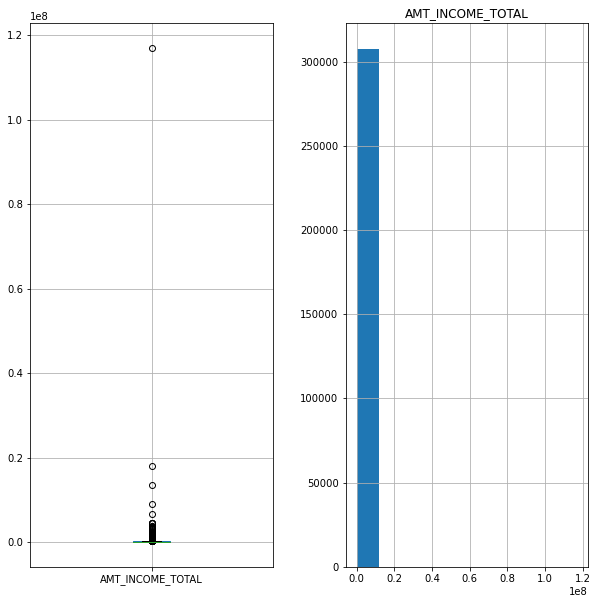

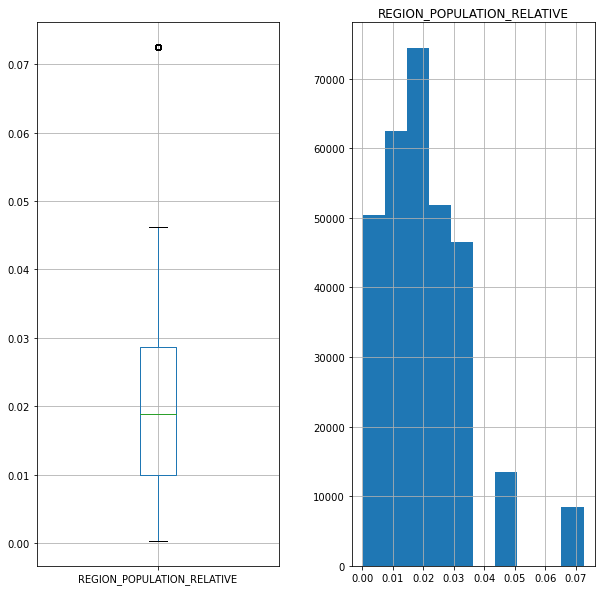

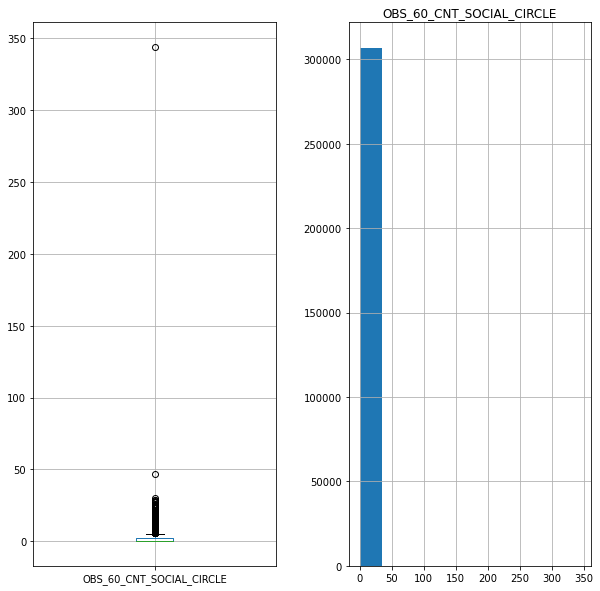

In [84]:
# 從上面的圖檢查的結果，至少這三個欄位好像有點可疑

# AMT_INCOME_TOTAL
# REGION_POPULATION_RELATIVE
# OBS_60_CNT_SOCIAL_CIRCLE
out = ['AMT_INCOME_TOTAL', 'REGION_POPULATION_RELATIVE', 'OBS_60_CNT_SOCIAL_CIRCLE']
for c in out:
    fig = plt.figure(figsize = (10, 10))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    app_train.boxplot(column = c, ax = ax1)
    app_train.hist(column = c, ax= ax2)
    plt.show();

### Hints: Emprical Cumulative Density Plot, [ECDF](https://zh.wikipedia.org/wiki/%E7%BB%8F%E9%AA%8C%E5%88%86%E5%B8%83%E5%87%BD%E6%95%B0), [ECDF with Python](https://stackoverflow.com/questions/14006520/ecdf-in-python-without-step-function)

經驗累積分布函數圖 ECDF(Empirical Cumulative Distribution Function)  
今天可能 outlier 他其實非常重要，單看何須圖或是長條圖無法判別，只好利用 ECDF

In [85]:
# 最大值離平均與中位數很遠
print(app_train['AMT_INCOME_TOTAL'].describe())

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64


In [105]:
# 繪製 Empirical Cumulative Density Plot (ECDF)
# sort_index: 根據 index 排序
# cumsum(): 累加總數
cdf = app_train['AMT_INCOME_TOTAL'].value_counts().sort_index().cumsum()
cdf
# cdf.index

25650.0             2
26100.0             5
26460.0             6
26550.0             8
27000.0            74
                ...  
6750000.0      307507
9000000.0      307508
13500000.0     307509
18000090.0     307510
117000000.0    307511
Name: AMT_INCOME_TOTAL, Length: 2548, dtype: int64

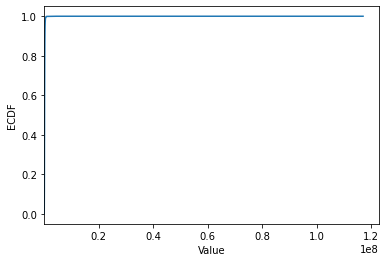

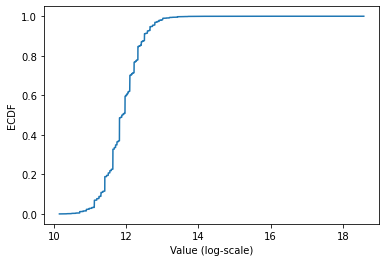

In [96]:
plt.plot(list(cdf.index), cdf/cdf.max())
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.xlim([cdf.index.min(), cdf.index.max() * 1.05]) # 限制顯示圖片的範圍
plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍

plt.show()

# 改變 y 軸的 Scale, 讓我們可以正常檢視 ECDF
plt.plot(np.log(list(cdf.index)), cdf/cdf.max())
plt.xlabel('Value (log-scale)')
plt.ylabel('ECDF')

plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍

plt.show()

## 補充：Normal dist 的 ECDF
![ecdf_normal](https://au.mathworks.com/help/examples/stats/win64/PlotEmpiricalCdfAndCompareWithSamplingDistributionExample_01.png)

In [97]:
# 最大值落在分布之外
print(app_train['REGION_POPULATION_RELATIVE'].describe())

count    307511.000000
mean          0.020868
std           0.013831
min           0.000290
25%           0.010006
50%           0.018850
75%           0.028663
max           0.072508
Name: REGION_POPULATION_RELATIVE, dtype: float64


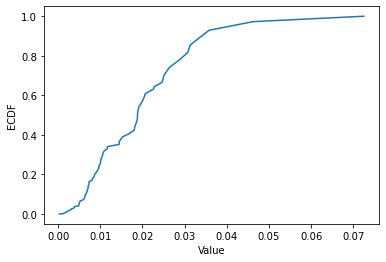

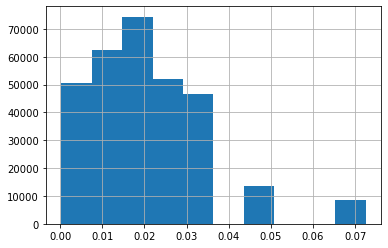

0.035792    16408
0.046220    13442
0.030755    12163
0.025164    11950
0.026392    11601
            ...  
0.001417      467
0.001333      235
0.000533       39
0.000938       28
0.000290        2
Name: REGION_POPULATION_RELATIVE, Length: 81, dtype: int64

In [98]:
# 繪製 Empirical Cumulative Density Plot (ECDF)
cdf = app_train['REGION_POPULATION_RELATIVE'].value_counts().sort_index().cumsum()

plt.plot(list(cdf.index), cdf/cdf.max())
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍
plt.show()

app_train['REGION_POPULATION_RELATIVE'].hist()
plt.show()

app_train['REGION_POPULATION_RELATIVE'].value_counts()

# 就以這個欄位來說，雖然有資料掉在分布以外，也不算異常，僅代表這間公司在稍微熱鬧的地區有的據點較少，
# 導致 region population relative 在少的部分較為密集，但在大的部分較為疏漏

In [106]:
# 最大值落在分布之外
print(app_train['OBS_60_CNT_SOCIAL_CIRCLE'].describe())

count    306490.000000
mean          1.405292
std           2.379803
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         344.000000
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: float64


In [108]:
# 繪製 Empirical Cumulative Density Plot (ECDF)
cdf = app_train['REGION_POPULATION_RELATIVE'].value_counts().sort_index().cumsum()
cdf

0.000290         2
0.000533        41
0.000938        69
0.001276       627
0.001333       862
             ...  
0.031329    262613
0.032561    269249
0.035792    285657
0.046220    299099
0.072508    307511
Name: REGION_POPULATION_RELATIVE, Length: 81, dtype: int64

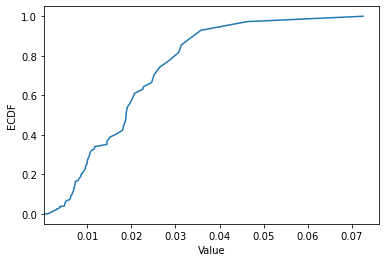

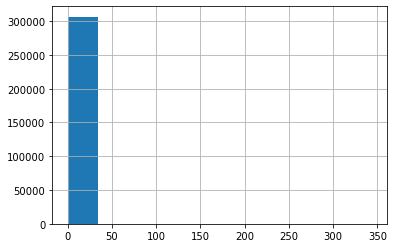

344.0         1
47.0          1
30.0          1
29.0          2
28.0          1
27.0          5
26.0          1
25.0         11
24.0         12
23.0         13
22.0         20
21.0         28
20.0         30
19.0         44
18.0         49
17.0         73
16.0        137
15.0        166
14.0        238
13.0        401
12.0        620
11.0        837
10.0       1335
9.0        1959
8.0        2886
7.0        4344
6.0        6349
5.0        9463
4.0       13946
3.0       20215
2.0       29766
1.0       48870
0.0      164666
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: int64


In [109]:
plt.plot(list(cdf.index), cdf/cdf.max())
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.xlim([cdf.index.min() * 0.95, cdf.index.max() * 1.05])
plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍
plt.show()

app_train['OBS_60_CNT_SOCIAL_CIRCLE'].hist()
plt.show()
print(app_train['OBS_60_CNT_SOCIAL_CIRCLE'].value_counts().sort_index(ascending = False))

## 注意：當 histogram 畫出上面這種圖 (只出現一條，但是 x 軸延伸很長導致右邊有一大片空白時，代表右邊有值但是數量稀少。這時可以考慮用 value_counts 去找到這些數值

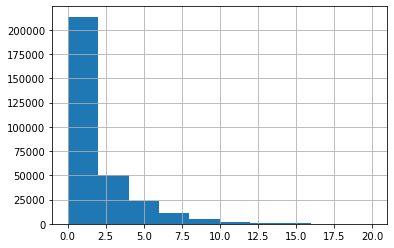

In [110]:
# 把一些極端值暫時去掉，在繪製一次 Histogram
# 選擇 OBS_60_CNT_SOCIAL_CIRCLE 小於 20 的資料點繪製
"""
Your Code Here
"""
loc_a = app_train["OBS_60_CNT_SOCIAL_CIRCLE"] <= 20
loc_b = 'OBS_60_CNT_SOCIAL_CIRCLE'

app_train.loc[loc_a, loc_b].hist()
plt.show()